### IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest


# evaluation metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

# scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# autoencoder
import tensorflow as tf
from tensorflow import keras

# deep learning
from keras.models import Model, Sequential
from keras import regularizers
from keras.layers import (
    Input,
    Conv1D,
    MaxPooling1D,
    Dense,
    Flatten,
    Dropout,
    BatchNormalization,
)
from keras.optimizers import Adam
import tensorflow 
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras import models,layers,activations,losses,optimizers,metrics
from tensorflow.keras.callbacks import EarlyStopping

### LOADING DATASET

In [2]:
credit_card = pd.read_excel("card transactions.xlsx")

### DATA PREPROCESSING 

In [3]:
credit_card.shape

(96753, 10)

In [4]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96753 entries, 0 to 96752
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             96753 non-null  int64         
 1   Cardnum            96753 non-null  int64         
 2   Date               96753 non-null  datetime64[ns]
 3   Merchnum           93378 non-null  object        
 4   Merch description  96753 non-null  object        
 5   Merch state        95558 non-null  object        
 6   Merch zip          92097 non-null  float64       
 7   Transtype          96753 non-null  object        
 8   Amount             96753 non-null  float64       
 9   Fraud              96753 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 7.4+ MB


### EXTRACT DAY AND MONTH FOR FURTHER ANALYSIS

In [5]:
day =pd.to_datetime(credit_card['Date']).dt.dayofweek
month =pd.to_datetime(credit_card['Date']).dt.month
credit_card.insert(1, 'day', day)
credit_card.insert(2, 'month', month)

### DELETING IRRELEVANT COLUMNS

In [6]:
credit_card = credit_card.drop('Date', axis = 1)
credit_card = credit_card.drop('Recnum', axis = 1)
credit_card = credit_card.drop('Transtype', axis = 1)
credit_card = credit_card.drop('Merch zip', axis = 1)

### CHECKING FOR NULL VALUES

In [7]:
credit_card.isnull().sum()

day                     0
month                   0
Cardnum                 0
Merchnum             3375
Merch description       0
Merch state          1195
Amount                  0
Fraud                   0
dtype: int64

### DROP THE NULL VALUES

In [8]:
credit_card['Merchnum'] = credit_card['Merchnum'].dropna()
credit_card['Merch state'] = credit_card['Merch state'].dropna()

In [9]:
credit_card.isnull().sum()

day                     0
month                   0
Cardnum                 0
Merchnum             3375
Merch description       0
Merch state          1195
Amount                  0
Fraud                   0
dtype: int64

In [10]:
credit_card[['day', 'month','Amount']].describe()

,day,month,Amount
count,96753.000000,96753.000000,9.675300e+04
mean,2.563218,6.327215,4.278857e+02
std,2.101681,3.241349,1.000614e+04
min,0.000000,1.000000,1.000000e-02
25%,1.000000,4.000000,3.348000e+01
50%,2.000000,6.000000,1.379800e+02
75%,5.000000,9.000000,4.282000e+02
max,6.000000,12.000000,3.102046e+06


### UNIQUE VALUES

In [11]:
dict_unique = {}
for i in credit_card.columns.to_list():
    dict_unique[i]=len(credit_card[i].unique())
dict_unique

{'day': 7,
 'month': 12,
 'Cardnum': 1645,
 'Merchnum': 13092,
 'Merch description': 13126,
 'Merch state': 228,
 'Amount': 34909,
 'Fraud': 2}

### CHECKING FOR DUPLICATES

In [12]:
credit_card.duplicated().sum()

6898

### STATISTICS SUMMARY

In [13]:
credit_card.describe()

,day,month,Cardnum,Amount,Fraud
count,96753.000000,96753.000000,9.675300e+04,9.675300e+04,96753.000000
mean,2.563218,6.327215,5.142202e+09,4.278857e+02,0.010945
std,2.101681,3.241349,5.567084e+04,1.000614e+04,0.104047
min,0.000000,1.000000,5.142110e+09,1.000000e-02,0.000000
25%,1.000000,4.000000,5.142152e+09,3.348000e+01,0.000000
50%,2.000000,6.000000,5.142196e+09,1.379800e+02,0.000000
75%,5.000000,9.000000,5.142246e+09,4.282000e+02,0.000000
max,6.000000,12.000000,5.142847e+09,3.102046e+06,1.000000


### EXPLORING THE DATASET

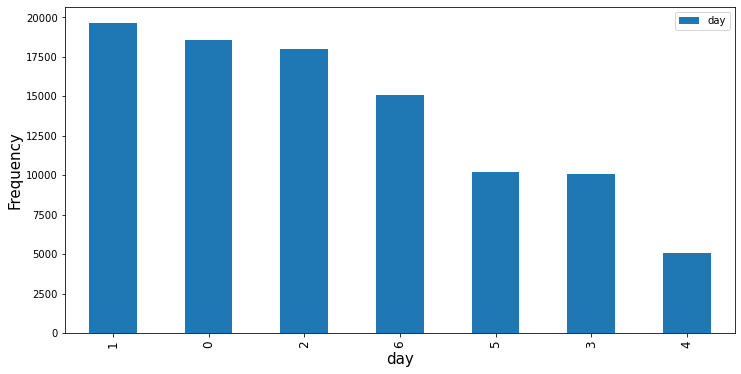

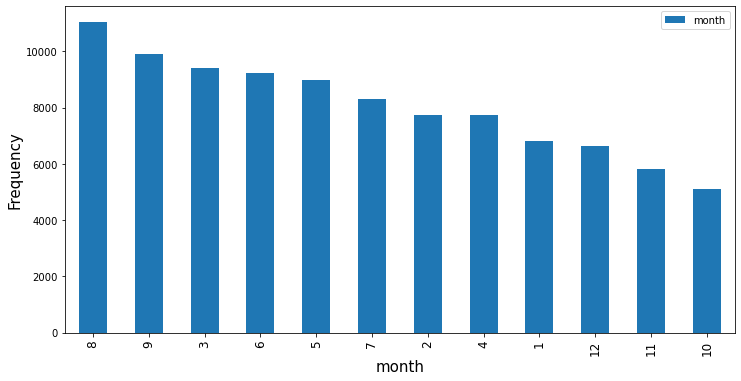

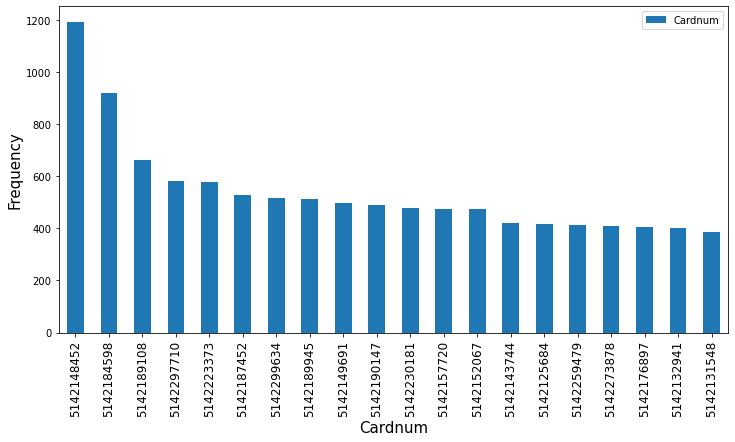

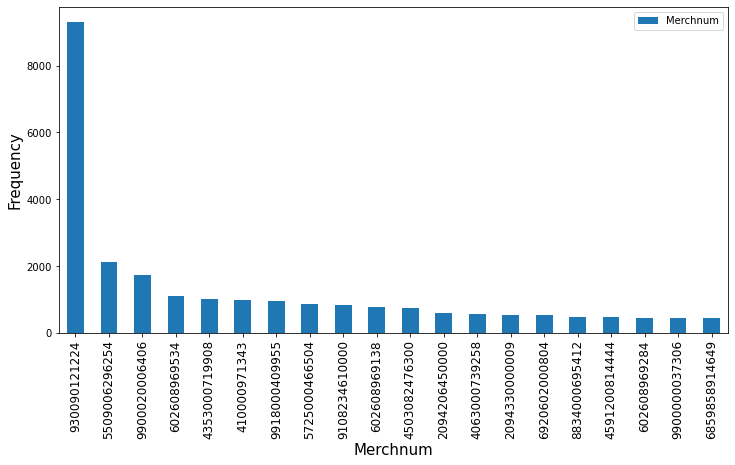

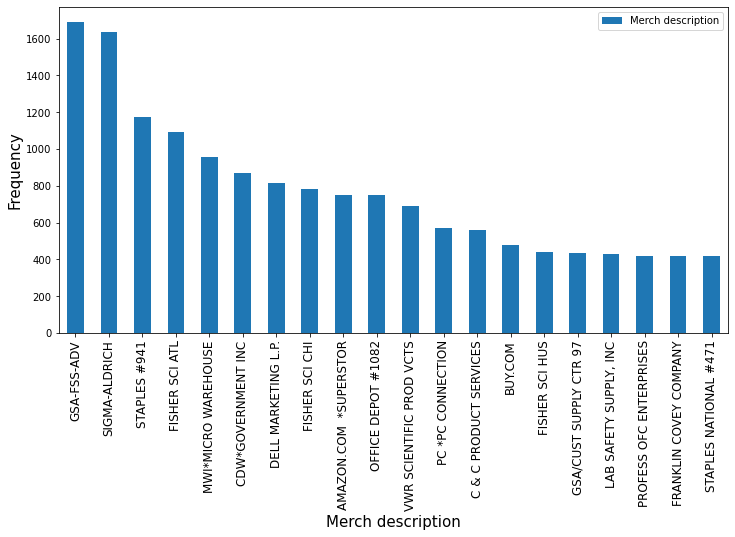

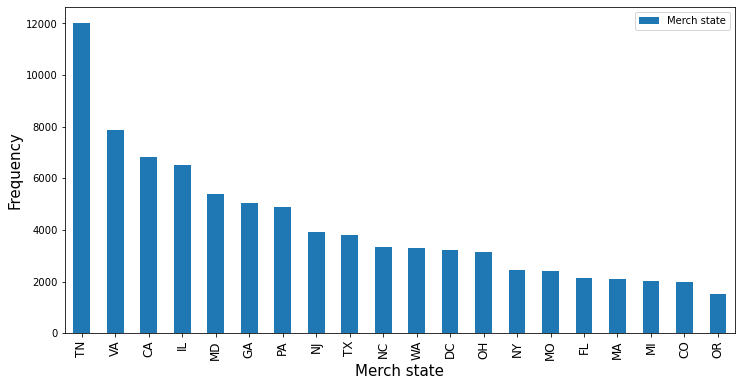

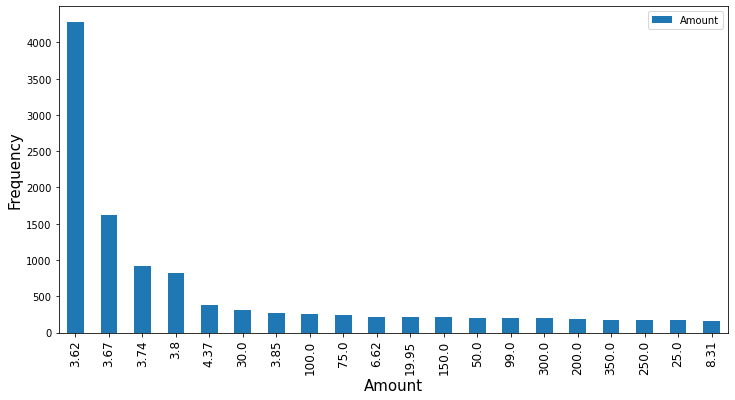

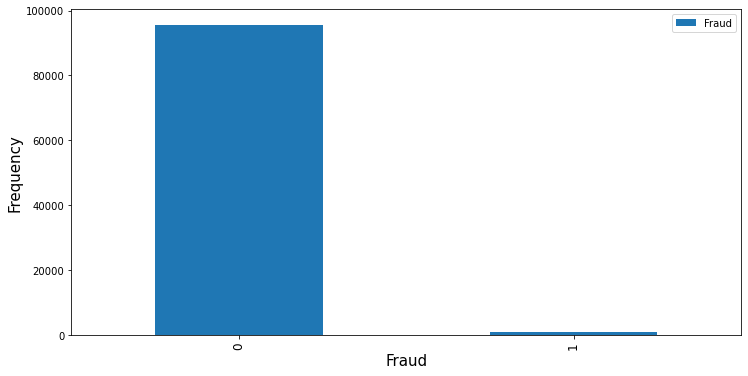

In [14]:
categoricalVar = credit_card.columns.tolist()
for col in categoricalVar:
    df = pd.DataFrame(credit_card[col].value_counts().sort_values(ascending=False).head(20))
    df.plot(kind='bar',figsize=(12,6))
    plt.xlabel(col,fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.xticks(fontsize=12)

### CORRELATION ANALYSIS

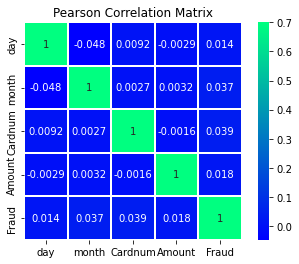

In [15]:
plt.title('Pearson Correlation Matrix')
sns.heatmap(credit_card.corr(),linewidths=0.25,vmax=0.7,square=True,cmap="winter",
            linecolor='w',annot=True);

The correlation plot shows no presence of multi collinearity amongst the features. All of these features does not show high correlation with the target class

### DISTRIBUTION OF TARGET CLASS

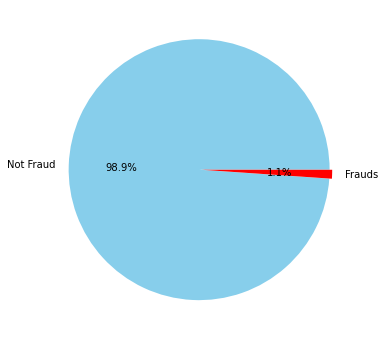

In [16]:
plt.figure(figsize=(10,6))
labels = ['Not Fraud' , 'Frauds']
explode = [.01,.01]
color = ['skyblue' , 'Red']
sizes = credit_card.Fraud.value_counts().values

plt.pie(sizes,explode,labels,autopct="%1.1f%%", colors = color)
plt.show()

The pie chart shows highly imbalanced dataset. 

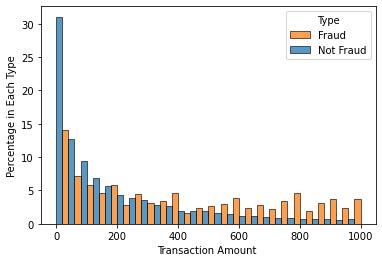

In [17]:
ax=sns.histplot(x='Amount',data=credit_card[credit_card.Amount<=1000],
                hue='Fraud',stat='percent',multiple='dodge',common_norm=False,bins=25)
ax.set_ylabel('Percentage in Each Type')
ax.set_xlabel('Transaction Amount ')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

### STATE VS FRAUD : let's also explore which geographies are more prone to fraud. 

Text(0.5, 1.0, 'The Percentage of Fraudulent over Non-Fraudulent Transcations in Each State')

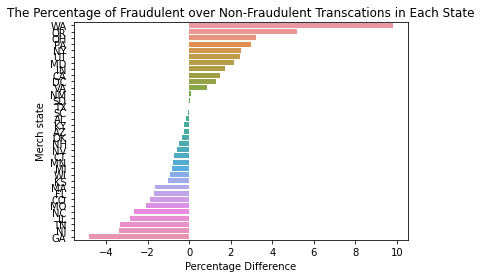

In [18]:
a=credit_card['Merch state'][credit_card.Fraud==0].value_counts(normalize=True)
a=a.to_frame()
a=a.reset_index()
a.columns = ['Merch state', 'Per']

b=credit_card['Merch state'][credit_card.Fraud==1].value_counts(normalize=True)
b=b.to_frame()
b=b.reset_index()
b.columns = ['Merch state', 'Per']

merged=a.merge(b,on='Merch state')
merged['diff']=merged['Per_y']-merged['Per_x']
merged['diff']=merged['diff']*100
merged=merged.sort_values('diff',ascending=False)

ax1=sns.barplot(data=merged, x='diff',y='Merch state')
ax1.set_xlabel('Percentage Difference')
ax1.set_ylabel('Merch state')
plt.title('The Percentage of Fraudulent over Non-Fraudulent Transcations in Each State')

### Monthly trends

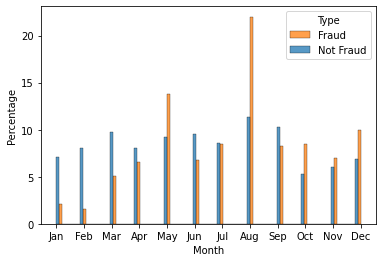

In [19]:
#month vs fraud
ax=sns.histplot(data=credit_card, x="month", hue="Fraud", common_norm=False,stat='percent',multiple='dodge')
ax.set_ylabel('Percentage')
ax.set_xlabel('Month')
plt.xticks(np.arange(1,13,1))
ax.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul",'Aug','Sep','Oct','Nov','Dec'])
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

### Daily trend

C:\Users\Home\AppData\Local\Temp\ipykernel_14512\3150562307.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['',"Mon","Tue","Wed","Thu","Fri","Sat","Sun"])


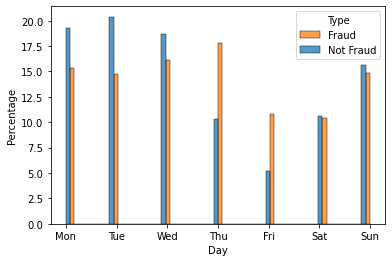

In [20]:
ax=sns.histplot(data = credit_card, x="day", hue="Fraud", common_norm=False,stat='percent',multiple='dodge')
ax.set_xticklabels(['',"Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
ax.set_ylabel('Percentage')
ax.set_xlabel('Day')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

### ENCODING INDEPENDENT VARIABLE

In [21]:
le = LabelEncoder()
credit_card["Merchnum"] = le.fit_transform(credit_card['Merchnum'])
credit_card["Merch description"] = le.fit_transform(credit_card['Merch description'])
credit_card["Merch state"] = le.fit_transform(credit_card['Merch state'])
credit_card

,day,month,Cardnum,Merchnum,Merch description,Merch state,Amount,Fraud
0,4,1,5142190439,4975,4594,217,3.62,0
1,4,1,5142183973,6735,10393,189,31.42,0
2,4,1,5142131721,3340,8454,191,178.49,0
3,4,1,5142148452,4975,4598,217,3.62,0
4,4,1,5142190439,4975,4594,217,3.62,0
...,...,...,...,...,...,...,...,...
96748,4,12,5142276053,2241,1534,187,84.79,0
96749,4,12,5142225701,9925,7247,207,118.75,0
96750,4,12,5142226486,3226,11299,207,363.56,0
96751,4,12,5142244619,10571,2093,174,2202.03,0


In [22]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96753 entries, 0 to 96752
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   day                96753 non-null  int64  
 1   month              96753 non-null  int64  
 2   Cardnum            96753 non-null  int64  
 3   Merchnum           96753 non-null  int32  
 4   Merch description  96753 non-null  int32  
 5   Merch state        96753 non-null  int32  
 6   Amount             96753 non-null  float64
 7   Fraud              96753 non-null  int64  
dtypes: float64(1), int32(3), int64(4)
memory usage: 4.8 MB


### FEATURE SCALING 

In [23]:
# Scale amount by log
# Adding a small amount of 0.0001 to amount as log of zero is infinite.
credit_card['amount_log'] = np.log(credit_card.Amount + 0.0001)
credit_card['Cardnum_log'] = np.log(credit_card.Cardnum + 0.0001)
credit_card['Merchnum_log'] = np.log(credit_card.Merchnum + 0.0001)
credit_card['Merch description_log'] = np.log(credit_card['Merch description'] + 0.0001)
credit_card['Merch state_log'] = np.log(credit_card['Merch state'] + 0.0001)
credit_card

,day,month,Cardnum,Merchnum,Merch description,Merch state,Amount,Fraud,amount_log,Cardnum_log,Merchnum_log,Merch description_log,Merch state_log
0,4,1,5142190439,4975,4594,217,3.62,0,1.286502,22.360745,8.512181,8.432506,5.379898
1,4,1,5142183973,6735,10393,189,31.42,0,3.447448,22.360744,8.815073,9.248888,5.241748
2,4,1,5142131721,3340,8454,191,178.49,0,5.184533,22.360734,8.113726,9.042395,5.252274
3,4,1,5142148452,4975,4598,217,3.62,0,1.286502,22.360737,8.512181,8.433377,5.379898
4,4,1,5142190439,4975,4594,217,3.62,0,1.286502,22.360745,8.512181,8.432506,5.379898
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96748,4,12,5142276053,2241,1534,187,84.79,0,4.440179,22.360762,7.714678,7.335634,5.231109
96749,4,12,5142225701,9925,7247,207,118.75,0,4.777021,22.360752,9.202812,8.888343,5.332719
96750,4,12,5142226486,3226,11299,207,363.56,0,5.895945,22.360752,8.078998,9.332470,5.332719
96751,4,12,5142244619,10571,2093,174,2202.03,0,7.697135,22.360756,9.265870,7.646354,5.159056


In [24]:
ss = StandardScaler() # object of the class StandardScaler ()
credit_card['amount_scaled'] = ss.fit_transform(credit_card['Amount'].values.reshape(-1,1))
credit_card['Cardnum_scaled'] = ss.fit_transform(credit_card['Cardnum'].values.reshape(-1,1))
credit_card['Merchnum_scaled'] = ss.fit_transform(credit_card['Merchnum'].values.reshape(-1,1))
credit_card['Merch description_scaled'] = ss.fit_transform(credit_card['Merch description'].values.reshape(-1,1))
credit_card['Merch state_scaled'] = ss.fit_transform(credit_card['Merch state'].values.reshape(-1,1))

credit_card

,day,month,Cardnum,Merchnum,Merch description,Merch state,Amount,Fraud,amount_log,Cardnum_log,Merchnum_log,Merch description_log,Merch state_log,amount_scaled,Cardnum_scaled,Merchnum_scaled,Merch description_scaled,Merch state_scaled
0,4,1,5142190439,4975,4594,217,3.62,0,1.286502,22.360745,8.512181,8.432506,5.379898,-0.042401,-0.203839,-0.611361,-0.498148,0.974765
1,4,1,5142183973,6735,10393,189,31.42,0,3.447448,22.360744,8.815073,9.248888,5.241748,-0.039622,-0.319986,-0.176560,1.157666,-0.590932
2,4,1,5142131721,3340,8454,191,178.49,0,5.184533,22.360734,8.113726,9.042395,5.252274,-0.024924,-1.258580,-1.015281,0.604015,-0.479096
3,4,1,5142148452,4975,4598,217,3.62,0,1.286502,22.360737,8.512181,8.433377,5.379898,-0.042401,-0.958044,-0.611361,-0.497006,0.974765
4,4,1,5142190439,4975,4594,217,3.62,0,1.286502,22.360745,8.512181,8.432506,5.379898,-0.042401,-0.203839,-0.611361,-0.498148,0.974765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96748,4,12,5142276053,2241,1534,187,84.79,0,4.440179,22.360762,7.714678,7.335634,5.231109,-0.034289,1.334030,-1.286785,-1.371884,-0.702767
96749,4,12,5142225701,9925,7247,207,118.75,0,4.777021,22.360752,9.202812,8.888343,5.332719,-0.030895,0.429566,0.611517,0.259375,0.415587
96750,4,12,5142226486,3226,11299,207,363.56,0,5.895945,22.360752,8.078998,9.332470,5.332719,-0.006429,0.443667,-1.043445,1.416361,0.415587
96751,4,12,5142244619,10571,2093,174,2202.03,0,7.697135,22.360756,9.265870,7.646354,5.159056,0.177306,0.769387,0.771108,-1.212270,-1.429698


In [25]:
from sklearn.preprocessing import MinMaxScaler

mm = MinMaxScaler() # object of the class StandardScaler ()
credit_card['amount_minmax'] = mm.fit_transform(credit_card['Amount'].values.reshape(-1,1))
credit_card['Cardnum_minmax'] = mm.fit_transform(credit_card['Cardnum'].values.reshape(-1,1))
credit_card['Merchnum_minmax'] = mm.fit_transform(credit_card['Merchnum'].values.reshape(-1,1))
credit_card['Merch description_minmax'] = mm.fit_transform(credit_card['Merch description'].values.reshape(-1,1))
credit_card['Merch state_minmax'] = mm.fit_transform(credit_card['Merch state'].values.reshape(-1,1))

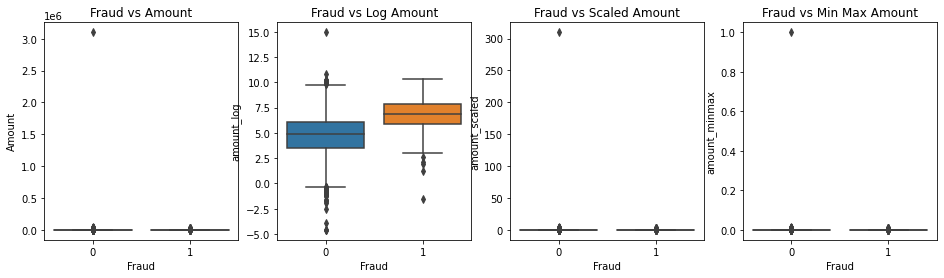

In [26]:
#Feature engineering to a better visualization of the values

# Let's explore the Amount by Class and see the distribuition of Amount transactions
fig , axs = plt.subplots(nrows = 1 , ncols = 4 , figsize = (16,4))

sns.boxplot(x ="Fraud",y="Amount",data=credit_card, ax = axs[0])
axs[0].set_title("Fraud vs Amount")

sns.boxplot(x ="Fraud",y="amount_log",data=credit_card, ax = axs[1])
axs[1].set_title("Fraud vs Log Amount")

sns.boxplot(x ="Fraud",y="amount_scaled",data=credit_card, ax = axs[2])
axs[2].set_title("Fraud vs Scaled Amount")

sns.boxplot(x ="Fraud",y="amount_minmax",data=credit_card, ax = axs[3])
axs[3].set_title("Fraud vs Min Max Amount")

# fig.suptitle('Amount by Class', fontsize=20)
plt.show()


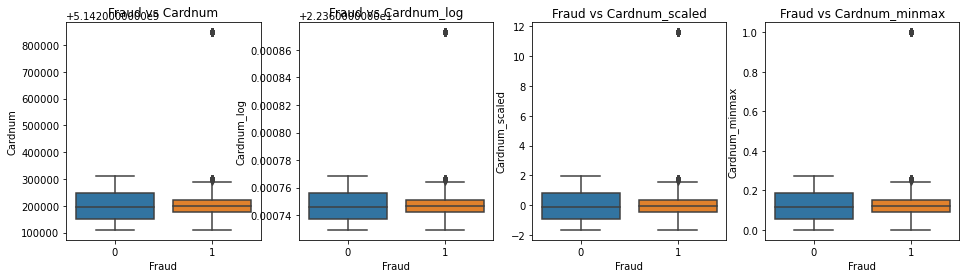

In [27]:
fig , axs = plt.subplots(nrows = 1 , ncols = 4 , figsize = (16,4))

sns.boxplot(x ="Fraud",y="Cardnum",data=credit_card, ax = axs[0])
axs[0].set_title("Fraud vs Cardnum")

sns.boxplot(x ="Fraud",y="Cardnum_log",data=credit_card, ax = axs[1])
axs[1].set_title("Fraud vs Cardnum_log")

sns.boxplot(x ="Fraud",y="Cardnum_scaled",data=credit_card, ax = axs[2])
axs[2].set_title("Fraud vs Cardnum_scaled")

sns.boxplot(x ="Fraud",y="Cardnum_minmax",data=credit_card, ax = axs[3])
axs[3].set_title("Fraud vs Cardnum_minmax")

# fig.suptitle('Amount by Class', fontsize=20)
plt.show()


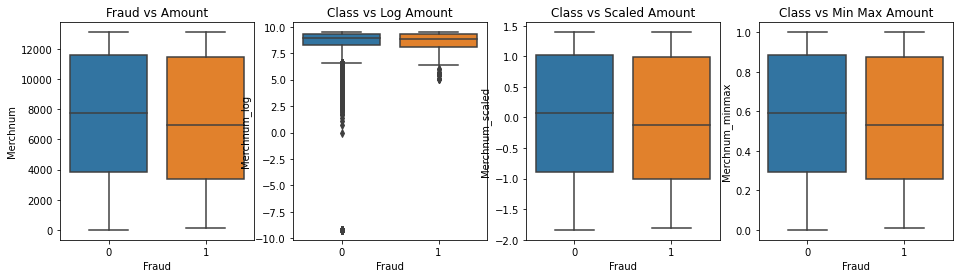

In [28]:
fig , axs = plt.subplots(nrows = 1 , ncols = 4 , figsize = (16,4))

sns.boxplot(x ="Fraud",y="Merchnum",data=credit_card, ax = axs[0])
axs[0].set_title("Fraud vs Amount")

sns.boxplot(x ="Fraud",y="Merchnum_log",data=credit_card, ax = axs[1])
axs[1].set_title("Class vs Log Amount")

sns.boxplot(x ="Fraud",y="Merchnum_scaled",data=credit_card, ax = axs[2])
axs[2].set_title("Class vs Scaled Amount")

sns.boxplot(x ="Fraud",y="Merchnum_minmax",data=credit_card, ax = axs[3])
axs[3].set_title("Class vs Min Max Amount")

# fig.suptitle('Amount by Class', fontsize=20)
plt.show()

We can see a slight difference in the log amount of our two Classes

In [29]:
df = credit_card[['day', 'month', 'Cardnum_minmax','Merchnum_log','Merch description_log', 'Merch state_log', 'amount_log','Fraud']]
df

,day,month,Cardnum_minmax,Merchnum_log,Merch description_log,Merch state_log,amount_log,Fraud
0,4,1,0.109083,8.512181,8.432506,5.379898,1.286502,0
1,4,1,0.100314,8.815073,9.248888,5.241748,3.447448,0
2,4,1,0.029454,8.113726,9.042395,5.252274,5.184533,0
3,4,1,0.052143,8.512181,8.433377,5.379898,1.286502,0
4,4,1,0.109083,8.512181,8.432506,5.379898,1.286502,0
...,...,...,...,...,...,...,...,...
96748,4,12,0.225186,7.714678,7.335634,5.231109,4.440179,0
96749,4,12,0.156902,9.202812,8.888343,5.332719,4.777021,0
96750,4,12,0.157967,8.078998,9.332470,5.332719,5.895945,0
96751,4,12,0.182557,9.265870,7.646354,5.159056,7.697135,0


In [30]:
print(df['Fraud'].value_counts())
print('\n')
print(df['Fraud'].value_counts(normalize=True))

0    95694
1     1059
Name: Fraud, dtype: int64


0    0.989055
1    0.010945
Name: Fraud, dtype: float64


In [31]:
#First Method of solving this problem which comes in mind will be by 
#taking same number of records of the majority class as the minority class
fraud_data = df.loc[df["Fraud"] == 1]
non_fraud_data = df.loc[df["Fraud"] == 0][:1059]

#concating the above dataframes to get a single dataframe
normal_distributed_df = pd.concat([fraud_data, non_fraud_data])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)
# setting up separate dataframes for fraud and non_fraud data for detailed analysis and comparison

print("Fraud Data Shape: ", fraud_data.shape)
print("Non-Fraud Data Shape: ", non_fraud_data.shape)

Fraud Data Shape:  (1059, 8)
Non-Fraud Data Shape:  (1059, 8)


In [32]:
#rescaling
df = pd.DataFrame(MinMaxScaler().fit_transform(new_df), columns=new_df.columns, index=new_df.index)
df

,day,month,Cardnum_minmax,Merchnum_log,Merch description_log,Merch state_log,amount_log,Fraud
510,0.166667,0.000000,0.236946,0.982398,0.622352,0.424602,0.438956,0.0
42,0.666667,0.000000,0.030540,0.948234,0.809080,0.902506,0.236602,0.0
273,0.000000,0.000000,0.110829,0.896280,0.854708,0.603547,0.560446,0.0
205,1.000000,0.000000,0.157090,0.927742,0.916187,0.580526,0.723455,0.0
65130,0.666667,0.636364,0.118227,0.866903,0.991795,0.841829,0.791622,1.0
...,...,...,...,...,...,...,...,...
583,0.166667,0.000000,0.067267,0.977959,0.592529,0.671178,0.600855,0.0
37,0.666667,0.000000,0.196729,0.958524,0.811871,0.912455,0.395045,0.0
72,0.833333,0.000000,0.127482,0.942099,0.854183,0.789931,0.381656,0.0
238,1.000000,0.000000,0.055924,0.930493,0.758648,0.912455,0.599360,0.0


#### We will build an Undercomplete Autoencoder with 7 input and output nodes that we squeeze down to 2 in the “bottleneck” layer.

In [33]:
#splitting the dataset to Create training and testing samples
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

X_train = X_train[X_train.Fraud == 0]
X_train = X_train.drop(['Fraud'], axis=1)

y_test = X_test['Fraud']
X_test = X_test.drop(['Fraud'], axis=1)

X_train = X_train
X_test = X_test
X_train.shape
X_test.shape

(424, 7)

In [34]:
X_test

,day,month,Cardnum_minmax,Merchnum_log,Merch description_log,Merch state_log,amount_log
95234,0.333333,1.000000,0.068313,0.787355,0.729832,0.831548,0.588559
625,0.166667,0.000000,0.194571,0.856335,0.857340,0.831548,0.624065
84,1.000000,0.000000,0.199361,0.978664,0.756704,0.424602,0.561351
70701,0.000000,0.727273,0.149919,0.840159,0.980240,0.545527,0.853804
575,0.166667,0.000000,0.122564,0.977823,0.959620,0.671178,0.621155
...,...,...,...,...,...,...,...
62309,0.333333,0.636364,0.118227,0.976082,0.810107,0.461594,0.755832
36646,0.000000,0.363636,0.118428,0.972343,0.818986,0.424602,0.668410
62696,0.500000,0.636364,0.118227,0.869024,0.921988,0.648868,0.668401
50516,0.000000,0.545455,0.090242,0.926157,0.919543,0.626326,0.735796


In [35]:
X_train.shape

(851, 7)

### UNDERCOMPLETE AUTOENCODER

The Autoencoder model for anomaly detection has some steps as follows: 

Step 1 is the encoder step. The essential information is extracted by a neural network model in this step.

Step 2 is the decoder step. In this step, the model reconstructs the data using the extracted information.

Step 3: Iterate step 1 and step 2 to adjust the model to minimize the difference between input and reconstructed output, until we get good reconstruction results for the training dataset.

Step 4: Make predictions on a dataset that includes outliers.

Step 5: Set up a threshold for outliers/anomalies by comparing the differences between the autoencoder model reconstruction value and the actual value.

Step 6: Identify the data points with the difference higher than the threshold to be outliers or anomalies.

In [36]:
# 'tanh' is used for the activation function of the encoded network 
# because it has big learning steps and results in strong or higher gradients

#relu is used on the bottle neck (latent low representation) 
#because model performance is better when trained with relu

#sigmoid is used for binary classification and since we have 
#fraud and non fraudclass then it is good for this problem

#In the input layer, we specified the shape of the dataset. 

In [37]:
from keras.models import Model, load_model # for creating a Neural Network Autoencoder model
from keras import Input # for instantiating a keras tensor
from keras.layers import Dense, LeakyReLU, BatchNormalization # for adding layers to AE model
from tensorflow.keras.utils import plot_model 

#--- Define Shapes
n_inputs=X_train.shape[1] # number of input neurons = the number of features in X_train
n_bottleneck= 2 

#--- Input Layer 
visible = Input(shape=(n_inputs,), name='Input-Layer') # Specify input shape

#--- Encoder Layer
e = Dense(units=n_inputs, name='Encoder-Layer')(visible)
e = BatchNormalization(name='Encoder-Layer-Normalization')(e)
e = LeakyReLU(name='Encoder-Layer-Activation')(e)

#--- Bottleneck
bottleneck = Dense(units=n_bottleneck, name='Bottleneck-Layer')(e)

#--- Decoder Layer
d = Dense(units=n_inputs, name='Decoder-Layer')(bottleneck)
d = BatchNormalization(name='Decoder-Layer-Normalization')(d)
d = LeakyReLU(name='Decoder-Layer-Activation')(d)

#--- Output layer
output = Dense(units=n_inputs, activation='linear', name='Output-Layer')(d)

# Define autoencoder model
model = Model(inputs=visible, outputs=output, name='Autoencoder-Model')

# Compile autoencoder model
model.compile(optimizer='adam', loss='mse')

# Print model summary
print(model.summary())

Model: "Autoencoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer (InputLayer)    [(None, 7)]               0         
                                                                 
 Encoder-Layer (Dense)       (None, 7)                 56        
                                                                 
 Encoder-Layer-Normalization  (None, 7)                28        
  (BatchNormalization)                                           
                                                                 
 Encoder-Layer-Activation (L  (None, 7)                0         
 eakyReLU)                                                       
                                                                 
 Bottleneck-Layer (Dense)    (None, 2)                 16        
                                                                 
 Decoder-Layer (Dense)       (None, 7)           

Epoch 1/100
14/14 [==============================] - 4s 62ms/step - loss: 0.8780 - val_loss: 0.4406
Epoch 2/100
14/14 [==============================] - 0s 12ms/step - loss: 0.7528 - val_loss: 0.4194
Epoch 3/100
14/14 [==============================] - 0s 13ms/step - loss: 0.6500 - val_loss: 0.4007
Epoch 4/100
14/14 [==============================] - 0s 12ms/step - loss: 0.5626 - val_loss: 0.3832
Epoch 5/100
14/14 [==============================] - 0s 12ms/step - loss: 0.4910 - val_loss: 0.3657
Epoch 6/100
14/14 [==============================] - 0s 13ms/step - loss: 0.4307 - val_loss: 0.3494
Epoch 7/100
14/14 [==============================] - 0s 15ms/step - loss: 0.3784 - val_loss: 0.3335
Epoch 8/100
14/14 [==============================] - 0s 15ms/step - loss: 0.3329 - val_loss: 0.3179
Epoch 9/100
14/14 [==============================] - 0s 13ms/step - loss: 0.2945 - val_loss: 0.3034
Epoch 10/100
14/14 [==============================] - 0s 14ms/step - loss: 0.2602 - val_loss: 0.2893

14/14 [==============================] - 0s 13ms/step - loss: 0.0132 - val_loss: 0.1637
Epoch 83/100
14/14 [==============================] - 0s 12ms/step - loss: 0.0125 - val_loss: 0.1623
Epoch 84/100
14/14 [==============================] - 0s 12ms/step - loss: 0.0126 - val_loss: 0.1647
Epoch 85/100
14/14 [==============================] - 0s 12ms/step - loss: 0.0122 - val_loss: 0.1666
Epoch 86/100
14/14 [==============================] - 0s 13ms/step - loss: 0.0123 - val_loss: 0.1629
Epoch 87/100
14/14 [==============================] - 0s 12ms/step - loss: 0.0121 - val_loss: 0.1660
Epoch 88/100
14/14 [==============================] - 0s 13ms/step - loss: 0.0123 - val_loss: 0.1672
Epoch 89/100
14/14 [==============================] - 0s 13ms/step - loss: 0.0123 - val_loss: 0.1625
Epoch 90/100
14/14 [==============================] - 0s 12ms/step - loss: 0.0118 - val_loss: 0.1645
Epoch 91/100
14/14 [==============================] - 0s 12ms/step - loss: 0.0121 - val_loss: 0.1653
Epo

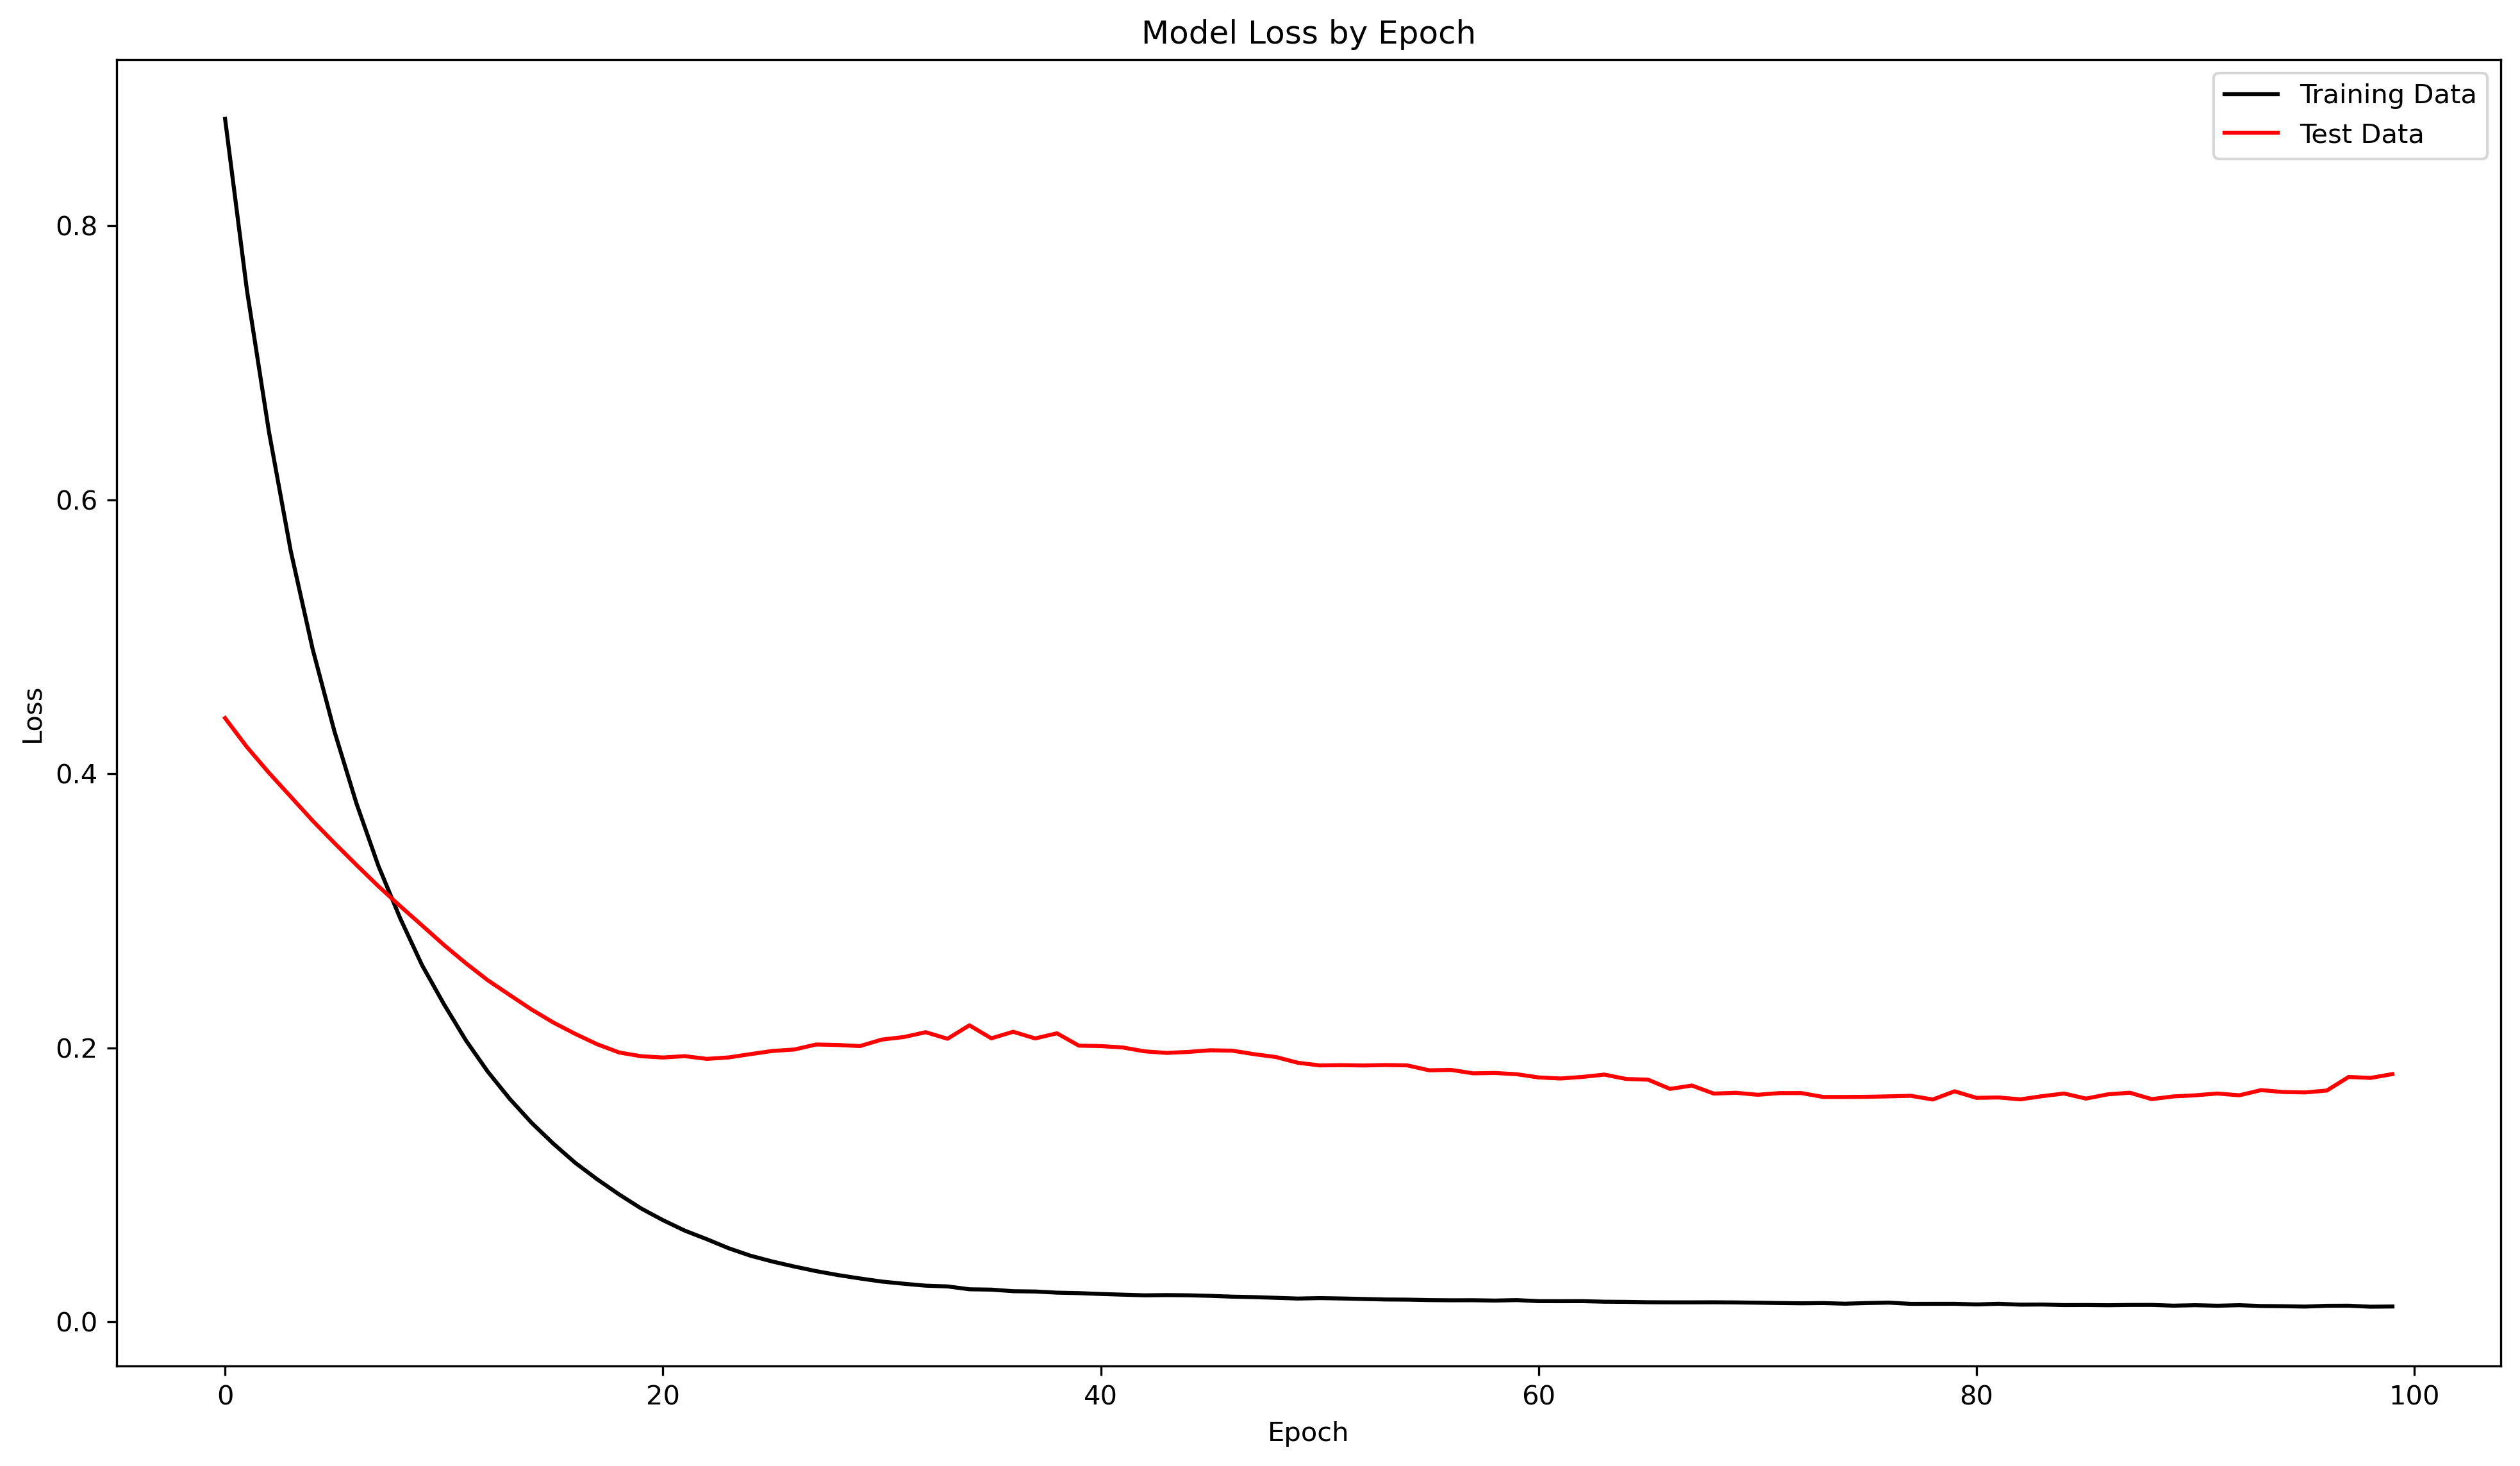

In [38]:
# Fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=100, batch_size=64, verbose=1, validation_data=(X_test, X_test))

# Plot a loss chart
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.legend()

plt.show()


When fitting the autoencoder model, we can see that the input and output datasets are the same,
which is the dataset that contains only the normal data points.

Shuffle=True will shuffle the dataset before each epoch.

Training the auto encoder model on non fraud data 

In [39]:
# Other utilities
import sys
import os
main_dir=os.path.dirname(sys.path[0])
#print(main_dir)

In [40]:
# Plot the autoencoder model diagram
from tensorflow.keras.utils import plot_model
plot_model(model, to_file=main_dir+'/pics/Autoencoder.png', show_shapes=True, dpi=300)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


We can see that our Autoencoder model was able to reconstruct the data with only a minimal loss.

The final part separates Encoder from Decoder and saves the model.

In [41]:
# Define an encoder model without the decoder
encoder = Model(inputs=visible, outputs=bottleneck)

# Compile encoder model
encoder.compile(optimizer='adam', loss='mse')

# Save the encoder model to file
encoder.save(main_dir+'/data/encoder.h5')

# Plot the autoencoder model diagram
plot_model(encoder, to_file=main_dir+'/pics/Encoder_only.png', show_shapes=True, dpi=300)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [42]:
# Load the model from file
encoder = load_model(main_dir+'/data/encoder.h5')

# Encode train and test data
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

14/14 [==============================] - 0s 3ms/step


In [43]:
#we have an autoencoder model, let's use it to predict the outliers.
#Firstly, we use .predict to get the reconstruction value for the testing data 
#set containing the usual data points and the outliers.

# Predict anomalies/outliers in the training dataset
prediction = model.predict(X_test)

14/14 [==============================] - 0s 3ms/step


In [44]:
#mse and reconstruction error
mse = np.mean(np.power(X_test - prediction, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [45]:
error_df

,reconstruction_error,true_class
95234,0.903727,1.0
625,0.014350,0.0
84,0.016343,0.0
70701,0.398803,1.0
575,0.017274,0.0
...,...,...
62309,0.369986,1.0
36646,0.112431,1.0
62696,0.335006,1.0
50516,0.202832,1.0


In [46]:
error_df.describe()

,reconstruction_error,true_class
count,424.000000,424.000000
mean,0.180790,0.509434
std,0.224161,0.500502
min,0.002561,0.000000
25%,0.015029,0.000000
50%,0.055142,1.000000
75%,0.296665,1.000000
max,1.005641,1.000000


In [47]:
# Get the mean squared error between actual and reconstruction/prediction
prediction_loss = tf.keras.losses.mse(prediction, X_test)

In [48]:
# Check the prediction loss threshold for 50% of outliers
loss_threshold = np.quantile(prediction_loss, 0.75)
print(f'The prediction loss threshold for 75% of outliers is {loss_threshold:.2f}')

The prediction loss threshold for 75% of outliers is 0.30


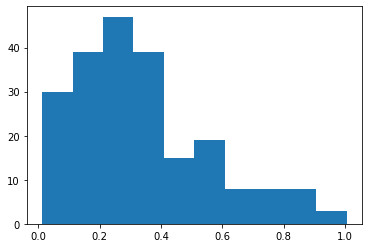

In [49]:
#Reconstruction error with fraud

fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1.0]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [50]:
# Check the model performance at 50% threshold
threshold_prediction = [0 if i < loss_threshold else 1 for i in prediction_loss]
threshold_prediction

[1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,


In [51]:
#Area under curve
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

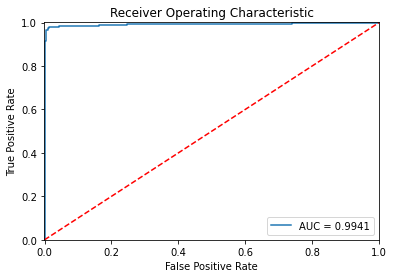

In [52]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

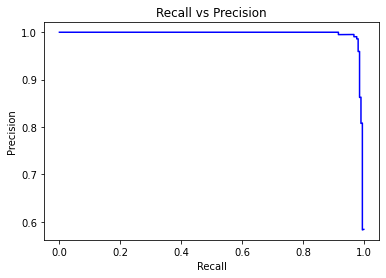

In [53]:
precision, recall,th= precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

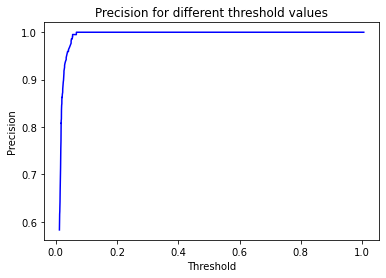

In [54]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

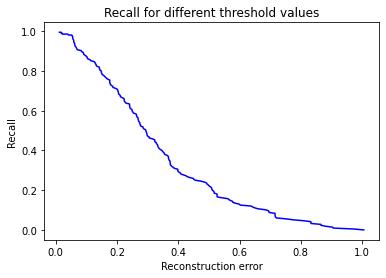

In [55]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [56]:
threshold = 0.30

In [57]:
pred_y = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]

In [58]:
predictions = pd.DataFrame({'true': error_df.true_class,
                           'predicted': pred_y})

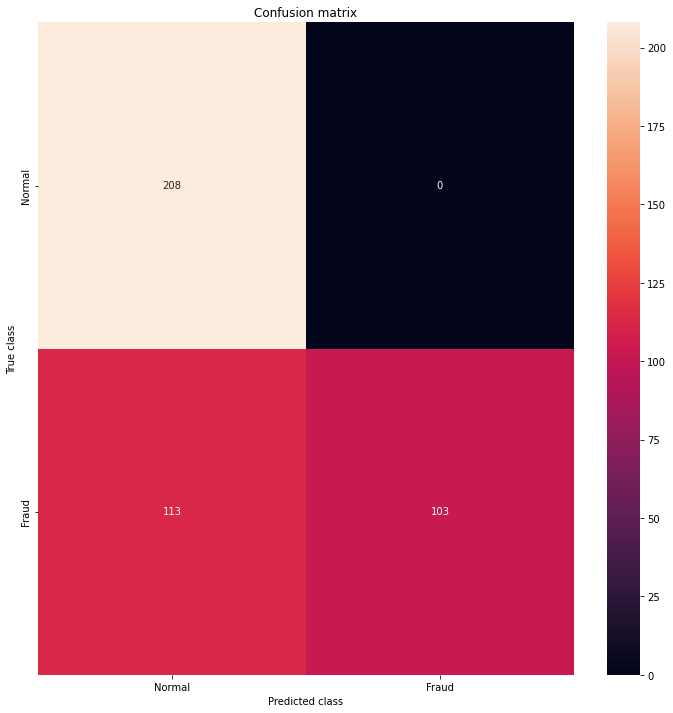

In [59]:
conf_matrix = confusion_matrix(error_df.true_class, pred_y)
conf_matrix
plt.figure(figsize=(12, 12))
LABELS = ['Normal', 'Fraud']
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [60]:
# Check the prediction performance
print(classification_report(y_test, pred_y))

              precision    recall  f1-score   support

         0.0       0.65      1.00      0.79       208
         1.0       1.00      0.48      0.65       216

    accuracy                           0.73       424
   macro avg       0.82      0.74      0.72       424
weighted avg       0.83      0.73      0.71       424



### VARIATIONAL AUTOENCODER

In [61]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [62]:
batch_size = 64
original_dim = (X_train.shape[1])
latent_dim = 2
intermediate_dim1 = 20
intermediate_dim2 = 10
epochs = 100
epsilon_std = 1.0

In [63]:
# sampling from mean and sd in VAE
def sampling(args: tuple):
    # we grab the variables from the tuple
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [64]:
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras import backend as K

#########################
# input to our encoder
#########################
x = Input(shape=(original_dim,), name="input")
# intermediate layer
#h1 = Dense(intermediate_dim1, activation='tanh', name="encoding1")(x)
h1 = Dense(intermediate_dim1, activation="tanh", name="encoding1", activity_regularizer=regularizers.l1(10e-5))(x)
h = Dense(intermediate_dim2, activation='tanh', name="encoding")(h1)
# defining the mean of the latent space
z_mean = Dense(latent_dim, name="mean")(h)
# defining the log variance of the latent space
z_log_var = Dense(latent_dim, name="log-variance")(h)
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
# defining the encoder as a keras model
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
# print out summary of what we just did
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 7)]          0           []                               
                                                                                                  
 encoding1 (Dense)              (None, 20)           160         ['input[0][0]']                  
                                                                                                  
 encoding (Dense)               (None, 10)           210         ['encoding1[0][0]']              
                                                                                                  
 mean (Dense)                   (None, 2)            22          ['encoding[0][0]']               
                                                                                            

In [61]:
#########################
# Input to the decoder
#########################

input_decoder = Input(shape=(latent_dim,), name="decoder_input")

# taking the latent space to intermediate dimension
decoder_h1 = Dense(intermediate_dim2, activation='relu', name="decoder_h2")(input_decoder)
decoder_h = Dense(intermediate_dim1, activation='relu', name="decoder_h")(decoder_h1)

# getting the mean from the original dimension
x_decoded = Dense(original_dim, activation='tanh', name="flat_decoded")(decoder_h)

# defining the decoder as a keras model
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 decoder_h2 (Dense)          (None, 10)                30        
                                                                 
 decoder_h (Dense)           (None, 20)                220       
                                                                 
 flat_decoded (Dense)        (None, 7)                 147       
                                                                 
Total params: 397
Trainable params: 397
Non-trainable params: 0
_________________________________________________________________


In [62]:
##########################
# Variational Autoencoder
##########################

# grab the output. Recall, that we need to grab the 3rd element our sampling z
output_combined = decoder(encoder(x)[2])

# link the input and the overall output
vae = Model(x, output_combined)

# print out what the overall model looks like
vae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 7)]               0         
                                                                 
 encoder (Functional)        [(None, 2),               414       
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 7)                 397       
                                                                 
Total params: 811
Trainable params: 811
Non-trainable params: 0
_________________________________________________________________


In [63]:
# Defina VAE Loss Function
def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor,z_log_var=z_log_var, z_mean=z_mean, original_dim=original_dim):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

In [64]:
vae.compile(optimizer='adam', loss=vae_loss, metrics=['accuracy'],experimental_run_tf_function=False)

In [65]:
history = vae.fit(X_train, X_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1).history

Train on 851 samples, validate on 424 samples
Epoch 1/100
851/851 [==============================] - 0s 251us/sample - loss: 37.4059 - accuracy: 0.0235 - val_loss: 42.7569 - val_accuracy: 0.0354
Epoch 2/100
851/851 [==============================] - 0s 29us/sample - loss: 34.5139 - accuracy: 0.0200 - val_loss: 40.1018 - val_accuracy: 0.0472
Epoch 3/100
851/851 [==============================] - 0s 13us/sample - loss: 32.4273 - accuracy: 0.0306 - val_loss: 37.5574 - val_accuracy: 0.0448
Epoch 4/100
851/851 [==============================] - 0s 15us/sample - loss: 30.7898 - accuracy: 0.0505 - val_loss: 35.0012 - val_accuracy: 0.0613
Epoch 5/100
851/851 [==============================] - 0s 15us/sample - loss: 27.6057 - accuracy: 0.0717 - val_loss: 32.6477 - val_accuracy: 0.0613
Epoch 6/100
851/851 [==============================] - 0s 14us/sample - loss: 25.5729 - accuracy: 0.0646 - val_loss: 30.4425 - val_accuracy: 0.1014
Epoch 7/100
851/851 [==============================] - 0s 13us/sa

C:\Users\Home\anaconda3\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Epoch 9/100
851/851 [==============================] - 0s 13us/sample - loss: 20.9529 - accuracy: 0.1034 - val_loss: 26.2705 - val_accuracy: 0.1321
Epoch 10/100
851/851 [==============================] - 0s 16us/sample - loss: 19.4954 - accuracy: 0.1387 - val_loss: 24.4265 - val_accuracy: 0.1509
Epoch 11/100
851/851 [==============================] - 0s 15us/sample - loss: 17.4088 - accuracy: 0.1469 - val_loss: 22.3963 - val_accuracy: 0.1344
Epoch 12/100
851/851 [==============================] - 0s 15us/sample - loss: 15.5599 - accuracy: 0.1563 - val_loss: 19.4624 - val_accuracy: 0.1769
Epoch 13/100
851/851 [==============================] - 0s 18us/sample - loss: 13.4720 - accuracy: 0.1915 - val_loss: 17.3356 - val_accuracy: 0.1863
Epoch 14/100
851/851 [==============================] - 0s 17us/sample - loss: 11.8850 - accuracy: 0.1880 - val_loss: 15.1404 - val_accuracy: 0.2123
Epoch 15/100
851/851 [==============================] - 0s 15us/sample - loss: 10.9005 - accuracy: 0.1951 -

Text(0.5, 1.0, 'Loss Curves')

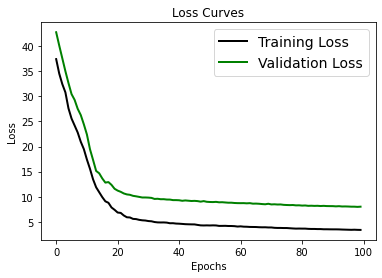

In [66]:
# plot loss history
loss = history['loss']
val_loss = history['val_loss']

# Loss curve

plt.plot(history["loss"], "black", linewidth=2.0)
plt.plot(history["val_loss"], "green", linewidth=2.0)
plt.legend(["Training Loss", "Validation Loss"], fontsize=14)
plt.xlabel("Epochs", fontsize=10)
plt.ylabel("Loss", fontsize=10)
plt.title("Loss Curves", fontsize=12)

In [67]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [68]:
##########################################
# prediction & reconstruction error
##################################

X_train_pred = vae.predict(X_train)

mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n75Q: {np.quantile(mae_vector, 0.75)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.75)} ')

error_thresh = np.quantile(mae_vector, 0.75)

Avg error 0.23549329426111987
median error 0.23030334805668368
99Q: 0.2634617996716726
setting threshold on 0.2634617996716726 


C:\Users\Home\anaconda3\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [69]:
X_pred = vae.predict(X_test)
mae_vector = get_error_term(X_pred, X_test, _rmse=False)
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)

0.5778301886792453

In [70]:
mse = np.mean(np.power(X_test - X_pred, 2), axis=1)
error_df_vae = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})
print("Full Sample",error_df.describe())
error_df_true = error_df_vae[(error_df_vae['true_class']== 0)]
print("Normal Sample",error_df_true.describe())
error_df_false = error_df_vae[(error_df_vae['true_class']== 1)]
print("Fraud Sample",error_df_false.describe())

Full Sample        reconstruction_error  true_class
count            424.000000  424.000000
mean               0.041888    0.509434
std                0.041308    0.500502
min                0.000434    0.000000
25%                0.009818    0.000000
50%                0.024439    1.000000
75%                0.063971    1.000000
max                0.190331    1.000000
Normal Sample        reconstruction_error  true_class
count            208.000000       208.0
mean               0.093976         0.0
std                0.035996         0.0
min                0.031639         0.0
25%                0.066760         0.0
50%                0.083733         0.0
75%                0.116452         0.0
max                0.208316         0.0
Fraud Sample        reconstruction_error  true_class
count            216.000000       216.0
mean               0.270185         1.0
std                0.104834         0.0
min                0.073458         1.0
25%                0.194273         1.0
5

In [71]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

In [72]:
from sklearn.metrics import classification_report

print(classification_report(y_test, anomalies))

              precision    recall  f1-score   support

         0.0       0.89      0.77      0.83       208
         1.0       0.80      0.91      0.85       216

    accuracy                           0.84       424
   macro avg       0.85      0.84      0.84       424
weighted avg       0.85      0.84      0.84       424



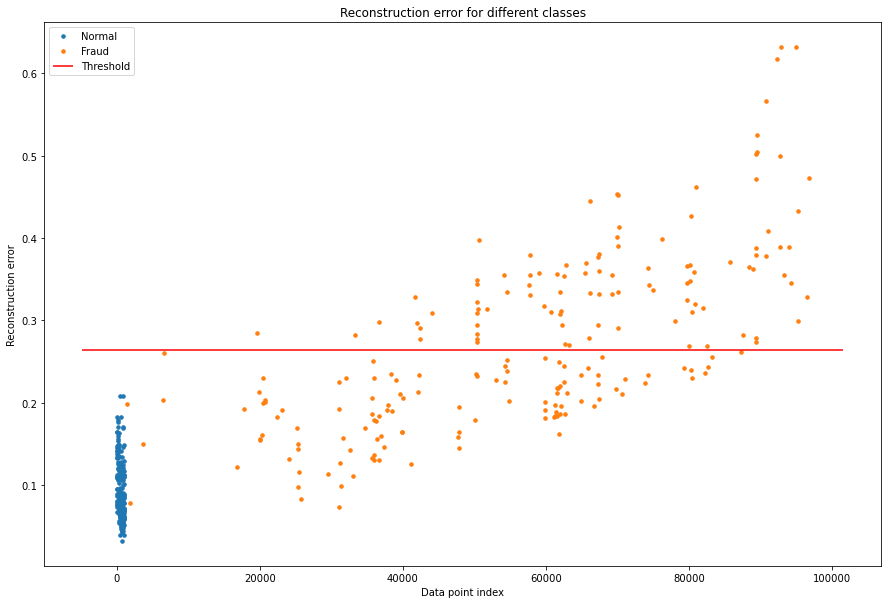

In [77]:
# scatter plot
threshold =0.2634617996716726 
groups = error_df_vae.groupby('true_class')
fig, ax = plt.subplots(figsize=(15, 10))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [78]:
# confusion matrix
threshold = 0.26257203225392023     

# And see how well we're dividing the two types of transactions:
groups = error_df.groupby('true_class')

# predict fraud
y_pred = [1 if e > error_thresh else 0 for e in error_df_vae.reconstruction_error.values]
y_pred

[1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,


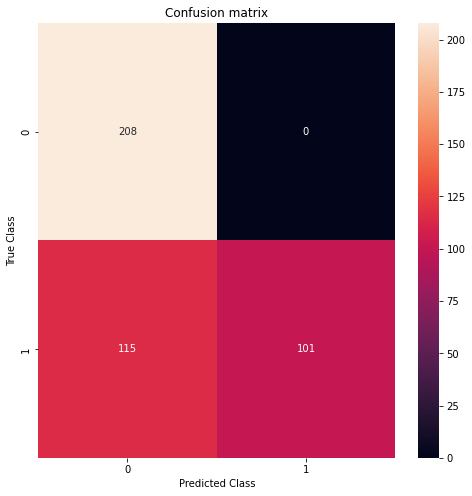

In [79]:
conf_matrix = confusion_matrix(error_df_vae.true_class, y_pred)
# plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

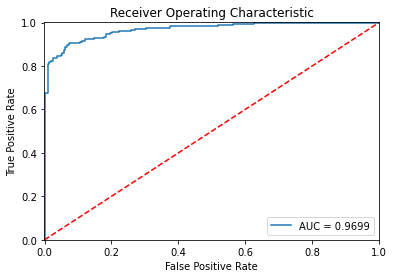

In [80]:
# ROC
fpr, tpr, thresholds = roc_curve(error_df_vae.true_class, error_df_vae.reconstruction_error)
roc_auc = auc(fpr, tpr)
# plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();